In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import openpyxl

import re

from datetime import timedelta

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, classification_report

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [2]:
# Загрузка данных
file_path = "C:\\Users\\dplog\\Downloads\\mastities_analytic_v2 (1).xlsx"  
df = pd.read_excel(file_path)

In [3]:
# Удаление строк, содержащих "Unknown" (без учета регистра и пробелов)
df = df[~df["DescriptionReport"].str.contains(r"\bUnknown\b", case=False, na=False)]

In [4]:
df

,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName
0,8036,Пташка,Ч/п голштинская-,4,2013-12-27 00:00:00,2009-07-24,Кл.маст. Кобакт,Абсцесс 30 d 1X1ml,Admin
1,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
2,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
3,103602,Нота,Ч/п голштинская,5,2016-02-24 00:00:00,2011-02-16,Гнойный абсцесс доли,Абсцесс 30 d 1X1ml,Admin
4,992,Абрикоса,Ч/п голштинская-,7,2012-09-02 00:00:00,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
...,...,...,...,...,...,...,...,...,...
11002,22824,Волга,Ч/п голштинская,1,2024-10-18 16:00:00,2022-07-13,Клинический мастит,"Тиломаст 3 d 1X1pcs Интрацистернально, Моксифо...",Семыкин А.К.
11003,20974,Горная,Ч/п голштинская,3,2024-10-20 14:00:00,2020-09-08,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11004,21822,Белка,Ч/п голштинская,2,2024-10-20 14:00:00,2021-07-23,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11005,171004,Опора,Jersey,5,2024-10-20 14:00:00,2017-11-13,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.


**Создаем словарь отдельным столбцом {схема лечения: доза,..}**

In [5]:
# Функция для извлечения действующих веществ и доз
def parse_multiple_descriptions(description):
    try:
        # Разделяем описание на отдельные препараты
        substances = re.split(r',\s*', description)
        result = {}
        
        # Обрабатываем каждый препарат
        for substance in substances:
            parts = substance.split()  # Разделяем по пробелам
            active_substance = parts[0]  # Первое слово — действующее вещество
            dose = next((p for p in parts if 'X' in p), None)  # Находим дозировку
            if dose:
                result[active_substance] = dose
        
        return result
    except Exception as e:
        return {"Ошибка": str(e)}

# Применение функции к столбцу DescriptionReport
df["ParsedReport"] = df["DescriptionReport"].apply(parse_multiple_descriptions)

# Вывод результата
df

,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName,ParsedReport
0,8036,Пташка,Ч/п голштинская-,4,2013-12-27 00:00:00,2009-07-24,Кл.маст. Кобакт,Абсцесс 30 d 1X1ml,Admin,{'Абсцесс': '1X1ml'}
1,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,{'Суб.клиника': '1X1ml'}
2,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,{'Суб.клиника': '1X1ml'}
3,103602,Нота,Ч/п голштинская,5,2016-02-24 00:00:00,2011-02-16,Гнойный абсцесс доли,Абсцесс 30 d 1X1ml,Admin,{'Абсцесс': '1X1ml'}
4,992,Абрикоса,Ч/п голштинская-,7,2012-09-02 00:00:00,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,{'Суб.клиника': '1X1ml'}
...,...,...,...,...,...,...,...,...,...,...
11002,22824,Волга,Ч/п голштинская,1,2024-10-18 16:00:00,2022-07-13,Клинический мастит,"Тиломаст 3 d 1X1pcs Интрацистернально, Моксифо...",Семыкин А.К.,"{'Тиломаст': '1X1pcs', 'Моксифорт': '1X60ml', ..."
11003,20974,Горная,Ч/п голштинская,3,2024-10-20 14:00:00,2020-09-08,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ..."
11004,21822,Белка,Ч/п голштинская,2,2024-10-20 14:00:00,2021-07-23,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ..."
11005,171004,Опора,Jersey,5,2024-10-20 14:00:00,2017-11-13,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,"{'Марбобел': '1X40ml', 'Клоксобел': '1X1pcs', ..."


**Анализ эффективности и зависимости**

In [6]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)

        for i, row in group.iterrows():
            # Пропустить записи, где уже указано "здоров" (без учета регистра)
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка эффективности
            effective = any("здоров" in x.lower() for x in follow_up["DiagName"])
            ineffective = any("здоров" not in x.lower() for x in follow_up["DiagName"])

            # Если эффективное лечение найдено и нет признаков рецидива
            is_effective = effective and not ineffective

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": is_effective
            })

    return pd.DataFrame(results)

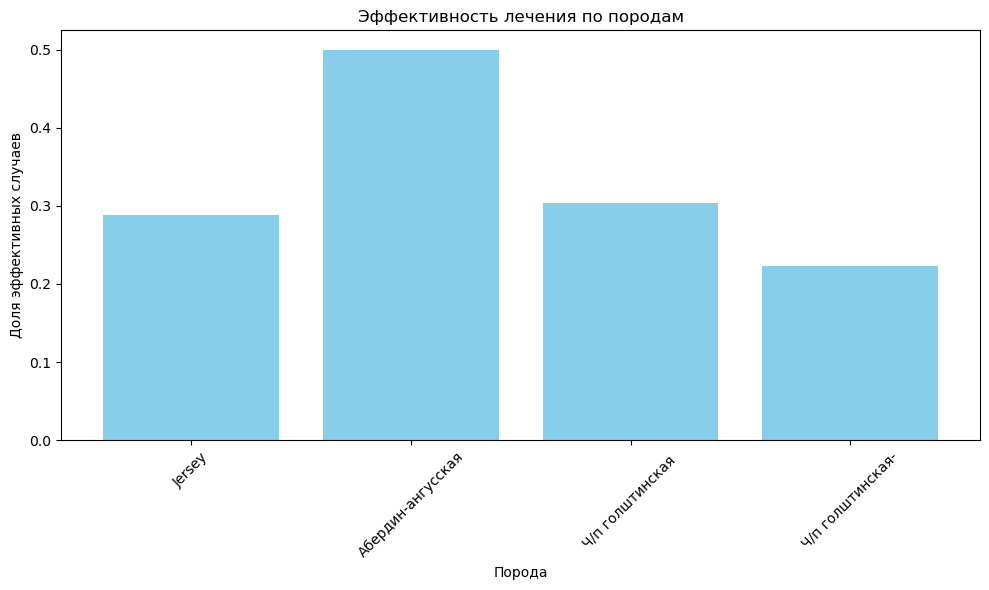

In [7]:
# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по породам
    breed_effectiveness = effectiveness_df.groupby("breed")["Effective"].mean().reset_index()

    # Группировка по числу отелов
    lactation_effectiveness = effectiveness_df.groupby("LactationNumber")["Effective"].mean().reset_index()

    # Визуализация эффективности по породам
    plt.figure(figsize=(10, 6))
    plt.bar(breed_effectiveness["breed"], breed_effectiveness["Effective"], color="skyblue")
    plt.title("Эффективность лечения по породам")
    plt.xlabel("Порода")
    plt.ylabel("Доля эффективных случаев")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
effectiveness_df

,number,breed,LactationNumber,DateAndTime,Treatment,Effective
0,10,Ч/п голштинская-,4,2013-10-30 00:00:00.000,Кл мас Синулокс 1 d 1X1ml,False
1,10,Ч/п голштинская-,4,2013-10-31 00:00:00.000,Кл мас Синулокс 1 d 1X1ml,False
2,10,Ч/п голштинская-,4,2013-11-02 00:00:00.000,Кл мас Синулокс 1 d 1X1ml,False
3,10,Ч/п голштинская-,4,2013-11-08 00:00:00.000,Кл мас Синулокс 1 d 1X1ml,False
4,10,Ч/п голштинская-,4,2014-04-16 00:00:00.000,Маст. клин. сеп 5 d 1X1ml,False
...,...,...,...,...,...,...
7468,254002,Ч/п голштинская-,5,2016-03-10 00:00:00.000,Кл мас Синулокс 1 d 1X1ml,False
7469,254002,Ч/п голштинская-,5,2016-03-22 00:00:00.000,Маст. клин. сеп 5 d 1X1ml,False
7470,254002,Ч/п голштинская-,5,2016-07-12 16:31:23.063,"Алезан гель 3 d 1X30ml Наружное, Травма гель 2...",False
7471,400002,Ч/п голштинская-,5,2016-10-24 17:07:53.617,"Алезан гель 3 d 1X30ml Наружное, Травма гель 2...",False


**Вывод:**<br/>
Эффективнсть лечения по породам, без учета доли каждой породы в общем количестве всей выборки. Наибольшую эффективнось лечения показала порода "Абердин-ангусская". 
Наименьшуж эффективность показала порода "Ч/п голшинская-".

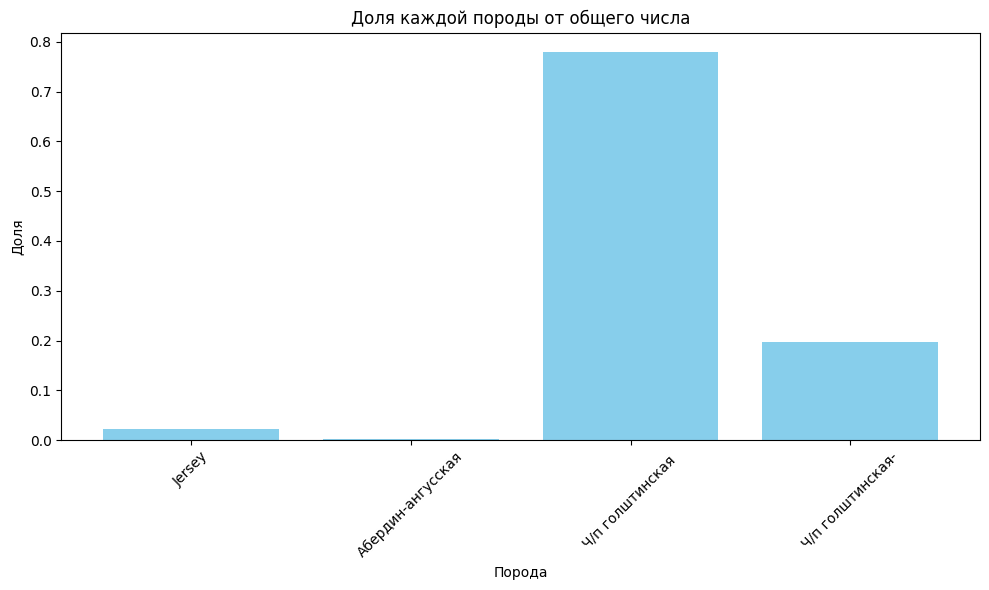

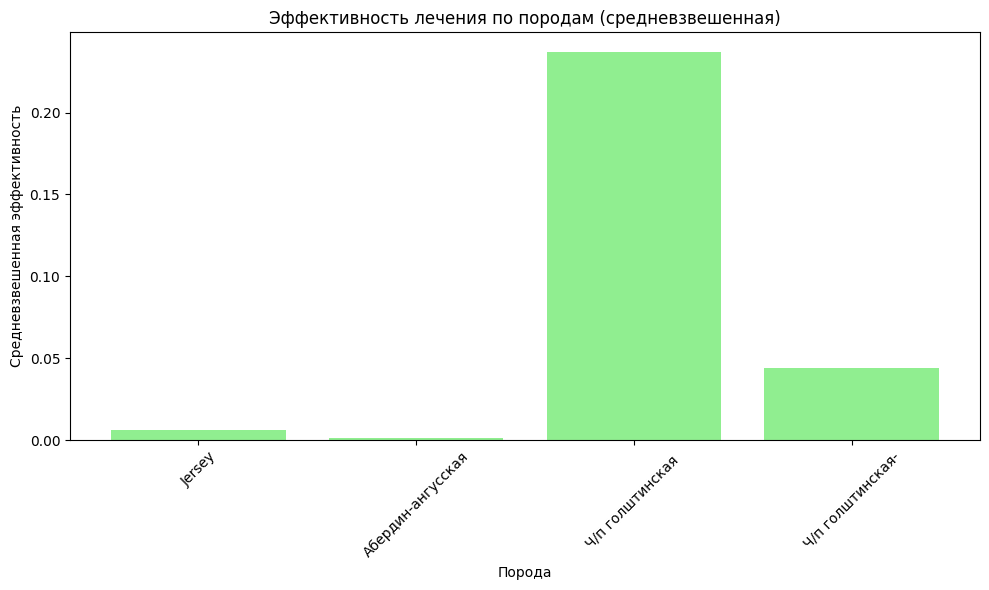

In [93]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)

        for i, row in group.iterrows():
            # Пропускаем, если запись уже содержит "Здоров" без учета регистра
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]

            # Проверка эффективности
            effective = (
                any("здоров" in x.lower() for x in follow_up["DiagName"]) and  # Лечение успешно
                not any("здоров" not in x.lower() and x.strip() for x in follow_up["DiagName"])  # Нет нового диагноза
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": effective
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness(df, days_after_treatment)

if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по породам
    breed_effectiveness = effectiveness_df.groupby("breed")["Effective"].mean().reset_index()

    # Считаем количество коров каждой породы
    breed_counts = df.groupby("breed")["number"].nunique().reset_index(name="Count")

    # Средневзвешенная эффективность
    breed_effectiveness = breed_effectiveness.merge(breed_counts, on="breed")
    breed_effectiveness["WeightedEffectiveness"] = breed_effectiveness["Effective"] * breed_effectiveness["Count"]

    # Доли пород
    breed_counts["Proportion"] = breed_counts["Count"] / breed_counts["Count"].sum()

    # Визуализация долей пород
    plt.figure(figsize=(10, 6))
    plt.bar(breed_counts["breed"], breed_counts["Proportion"], color="skyblue")
    plt.title("Доля каждой породы от общего числа")
    plt.xlabel("Порода")
    plt.ylabel("Доля")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Визуализация эффективности лечения по породам (средневзвешенной)
    breed_effectiveness["ProportionEffectiveness"] = breed_effectiveness["WeightedEffectiveness"] / breed_effectiveness["Count"].sum()

    plt.figure(figsize=(10, 6))
    plt.bar(breed_effectiveness["breed"], breed_effectiveness["ProportionEffectiveness"], color="lightgreen")
    plt.title("Эффективность лечения по породам (средневзвешенная)")
    plt.xlabel("Порода")
    plt.ylabel("Средневзвешенная эффективность")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Вывод:**<br/>
Доля каждой породы от общего чиста: самая большая доля: "Ч/п голштинская". Самая наименьшая доля: "Абердин-ангусская".<br/>
Эффективность лечения по породам (средневзвешенная): Наибольшую средневзвешенную эффективность лечения показала порода "Ч/п голштинская".<br/>

**Анализ неэффективного лечения по числу отелов и количеству предыдущих диагнозов**

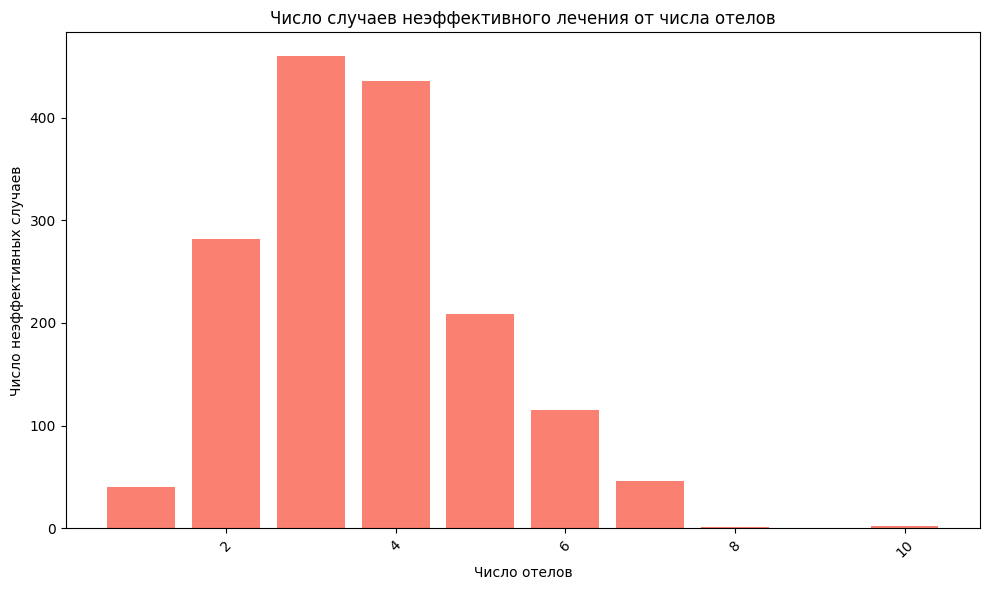

In [84]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness_with_previous_diagnoses(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)
        
        previous_healthy_cases = 0  # Счетчик записей, где корова была здорова

        for i, row in group.iterrows():
            # Подсчет предыдущих "здоровых" записей
            previous_healthy_cases += int("здоров" in row["DiagName"].lower())

            # Пропустить записи, где уже указано "здоров" (без учета регистра)
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка неэффективности: нет "здоров" в follow_up или есть другой диагноз
            ineffective = (
                not any("здоров" in x.lower() for x in follow_up["DiagName"]) and
                len(follow_up) > 0
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": not ineffective,
                "PreviousHealthyCases": previous_healthy_cases
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness_with_previous_diagnoses(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по числу отелов
    lactation_ineffective = effectiveness_df[~effectiveness_df["Effective"]].groupby("LactationNumber").size().reset_index(name="IneffectiveCount")

    # Группировка по количеству предыдущих диагнозов
    previous_healthy_ineffective = effectiveness_df[~effectiveness_df["Effective"]].groupby("PreviousHealthyCases").size().reset_index(name="IneffectiveCount")

    # Визуализация зависимости неэффективности от числа отелов
    plt.figure(figsize=(10, 6))
    plt.bar(lactation_ineffective["LactationNumber"], lactation_ineffective["IneffectiveCount"], color="salmon")
    plt.title("Число случаев неэффективного лечения от числа отелов")
    plt.xlabel("Число отелов")
    plt.ylabel("Число неэффективных случаев")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Вывод:** <br/>
Число случаев неэффективного лечения растет с число отелов линейно до 3 отела, потом экспоненциально падает. Падение возможно со сниженем также чила отелов после 3. 

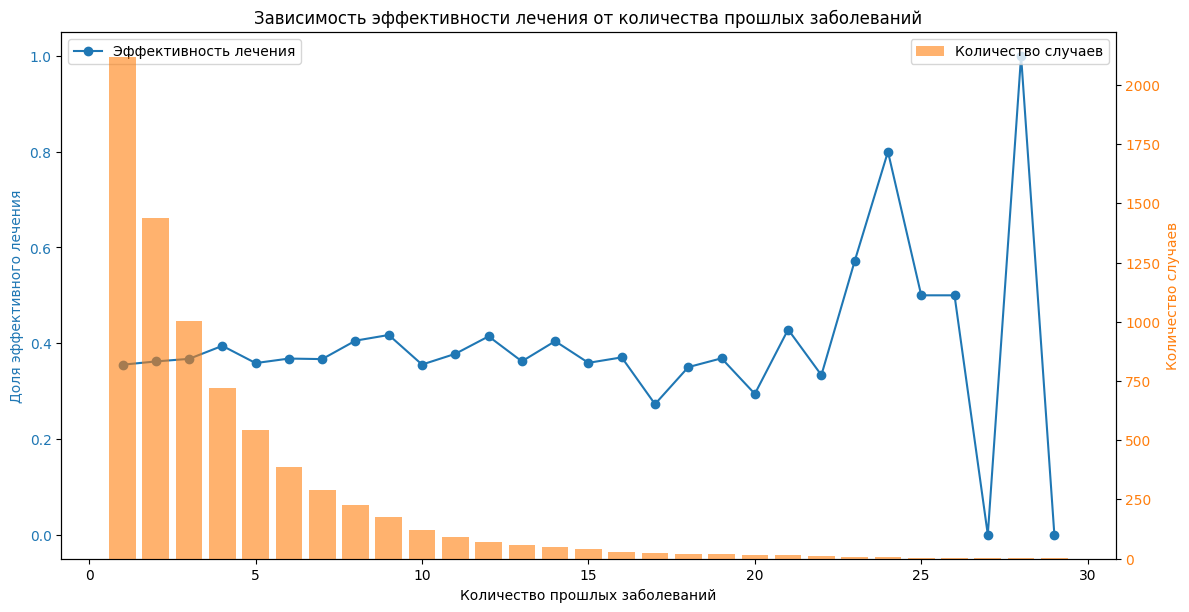

In [85]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

def analyze_treatment_effectiveness_with_past_illnesses(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)
        
        past_illnesses = 0  # Счетчик заболеваний (записей без "здоров")

        for i, row in group.iterrows():
            # Подсчет количества прошлых заболеваний
            if not ("здоров" in row["DiagName"].lower()):
                past_illnesses += 1

            # Пропустить записи, где уже указано "здоров" (без учета регистра)
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка эффективности
            effective = any("здоров" in x.lower() for x in follow_up["DiagName"]) and not (
                len(follow_up) > 0 and not any("здоров" in x.lower() for x in follow_up["DiagName"])
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": effective,
                "PastIllnesses": past_illnesses
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_treatment_effectiveness_with_past_illnesses(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по количеству прошлых заболеваний
    past_illness_effectiveness = effectiveness_df.groupby("PastIllnesses")["Effective"].mean().reset_index()
    past_illness_counts = effectiveness_df["PastIllnesses"].value_counts().reset_index()
    past_illness_counts.columns = ["PastIllnesses", "Count"]

    # Визуализация зависимости эффективности от количества прошлых заболеваний
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel("Количество прошлых заболеваний")
    ax1.set_ylabel("Доля эффективного лечения", color=color)
    ax1.plot(
        past_illness_effectiveness["PastIllnesses"],
        past_illness_effectiveness["Effective"],
        color=color,
        marker="o",
        label="Эффективность лечения"
    )
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()  # Вторая ось для количества случаев
    color = 'tab:orange'
    ax2.set_ylabel("Количество случаев", color=color)
    ax2.bar(
        past_illness_counts["PastIllnesses"],
        past_illness_counts["Count"],
        alpha=0.6,
        color=color,
        label="Количество случаев"
    )
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc="upper right")

    fig.tight_layout()
    plt.title("Зависимость эффективности лечения от количества прошлых заболеваний")
    plt.show()


**Вывод:** <br/>
Для всех пород эффективность лечения экпоненциально падает с ростом количества прошлых заболеваний. 

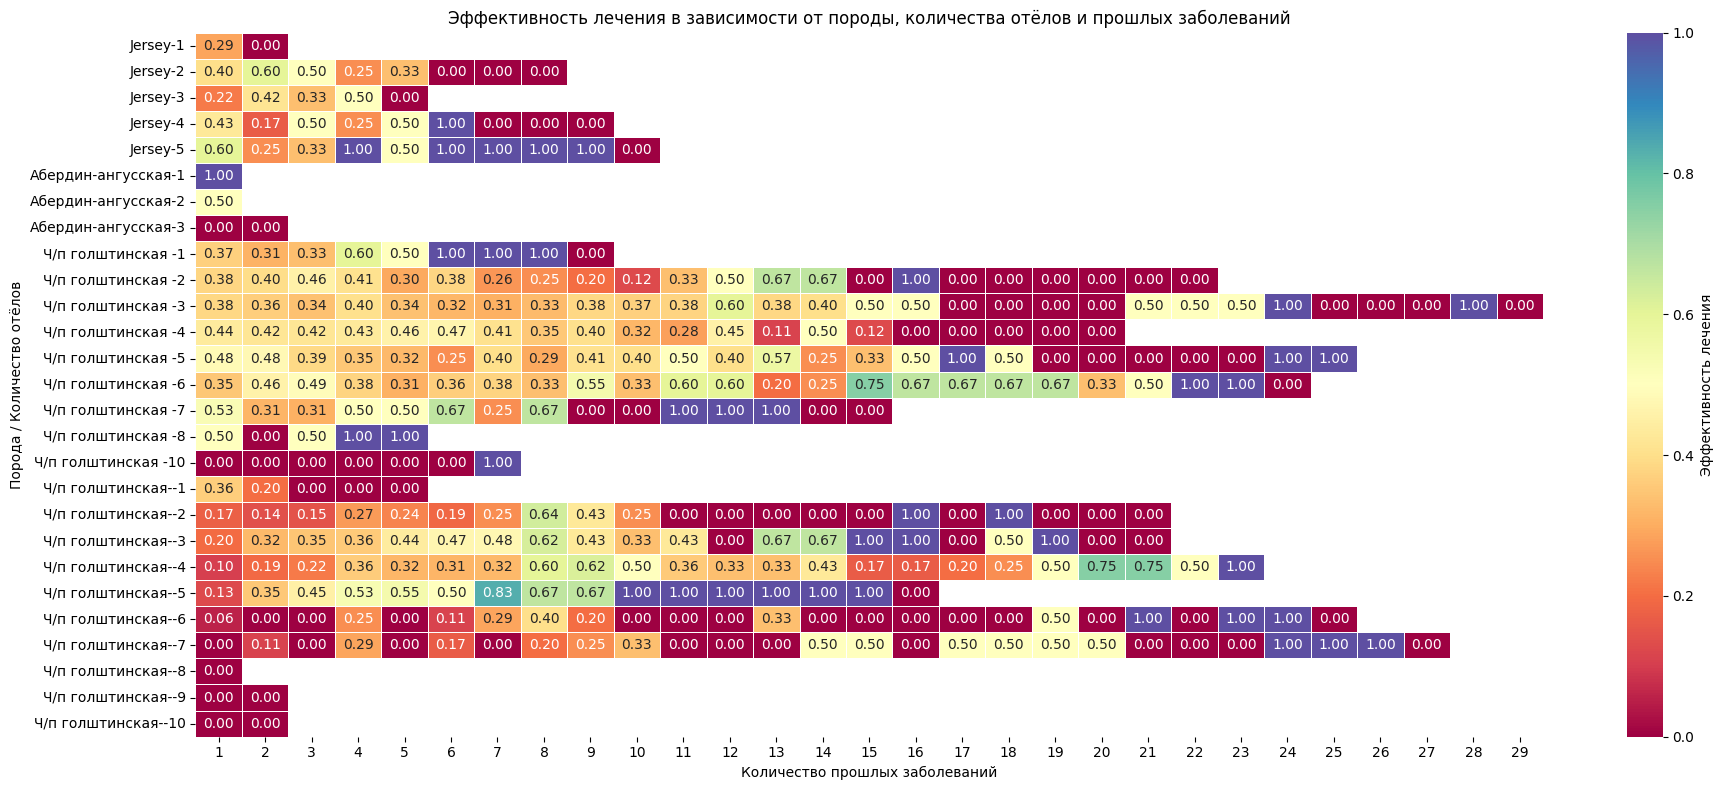

In [91]:
# Параметры
days_after_treatment = 14  # Количество дней для анализа эффективности

# Функция для анализа эффективности с учетом трех факторов
def analyze_effectiveness_with_factors(df, days_after_treatment):
    results = []

    # Убедимся, что DescriptionReport и DiagName содержат строки
    df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
    df["DiagName"] = df["DiagName"].fillna("").astype(str)

    # Группировка данных по коровам
    for cow_id, group in df.groupby("number"):
        group = group.sort_values("DateAndTime").reset_index(drop=True)
        
        past_illnesses = 0  # Счетчик заболеваний (записей без "здоров")

        for i, row in group.iterrows():
            # Подсчет количества прошлых заболеваний
            if not ("здоров" in row["DiagName"].lower()):
                past_illnesses += 1

            # Пропустить записи, где уже указано "здоров"
            if "здоров" in row["DiagName"].lower():
                continue

            treatment_date = row["DateAndTime"]
            follow_up_period = treatment_date + timedelta(days=days_after_treatment)

            # Найти записи после лечения
            follow_up = group[(group["DateAndTime"] > treatment_date) & (group["DateAndTime"] <= follow_up_period)]
            
            # Проверка эффективности
            effective = any("здоров" in x.lower() for x in follow_up["DiagName"]) and not (
                len(follow_up) > 0 and not any("здоров" in x.lower() for x in follow_up["DiagName"])
            )

            results.append({
                "number": cow_id,
                "breed": row["breed"],
                "LactationNumber": row["LactationNumber"],
                "DateAndTime": treatment_date,
                "Treatment": row["DescriptionReport"],
                "Effective": effective,
                "PastIllnesses": past_illnesses
            })

    return pd.DataFrame(results)

# Анализ эффективности
effectiveness_df = analyze_effectiveness_with_factors(df, days_after_treatment)

# Проверка наличия данных
if effectiveness_df.empty:
    print("Нет данных для анализа. Проверьте корректность столбцов DescriptionReport и DiagName.")
else:
    # Группировка по породе, количеству отёлов и прошлых заболеваниям
    grouped = effectiveness_df.groupby(["breed", "LactationNumber", "PastIllnesses"])["Effective"].mean().reset_index()

    # Визуализация зависимости
    pivot_table = grouped.pivot_table(
        index=["breed", "LactationNumber"], 
        columns="PastIllnesses", 
        values="Effective", 
        aggfunc="sum"
    )

    plt.figure(figsize=(19, 8))
    sns.heatmap(
        pivot_table, 
        cmap="Spectral", 
        annot=True, 
        fmt=".2f", 
        linewidths=0.5, 
        cbar_kws={'label': 'Эффективность лечения'}
    )
    plt.title("Эффективность лечения в зависимости от породы, количества отёлов и прошлых заболеваний")
    plt.xlabel("Количество прошлых заболеваний")
    plt.ylabel("Порода / Количество отёлов")
    plt.tight_layout()
    plt.show()

Для породы "Jersey" эффективность лечения падает после 6 раза заболевания (постанови диагноза). <br/>
Для породы "Ч/п Голштинская" эффективность лечения падает с ростом количества отелов: начиная с 7 отела резко падает эффективность дечения. Для этой породы с 10 отела дечение оказывается неэффективным независимо от 
количества предыдущих диагнзов.<br/>
Для породы "Ч/п Голштинская" эффективность лечения падает с ростом количества количества прощлых заболеваний: начиная с постновки 11 диагноза начинается резкий спад эффективноси лечения. <br/>
Порода "Голштинская-" менее устойчива к схемам лечения, начиная с первого отела и независимо от количества предыдущих заболевамний, относительно других пород, где явно прослеживается зависимость <br/>
эффективности лечения от количества отелов и количества предшествующих диагнозов.<br/>


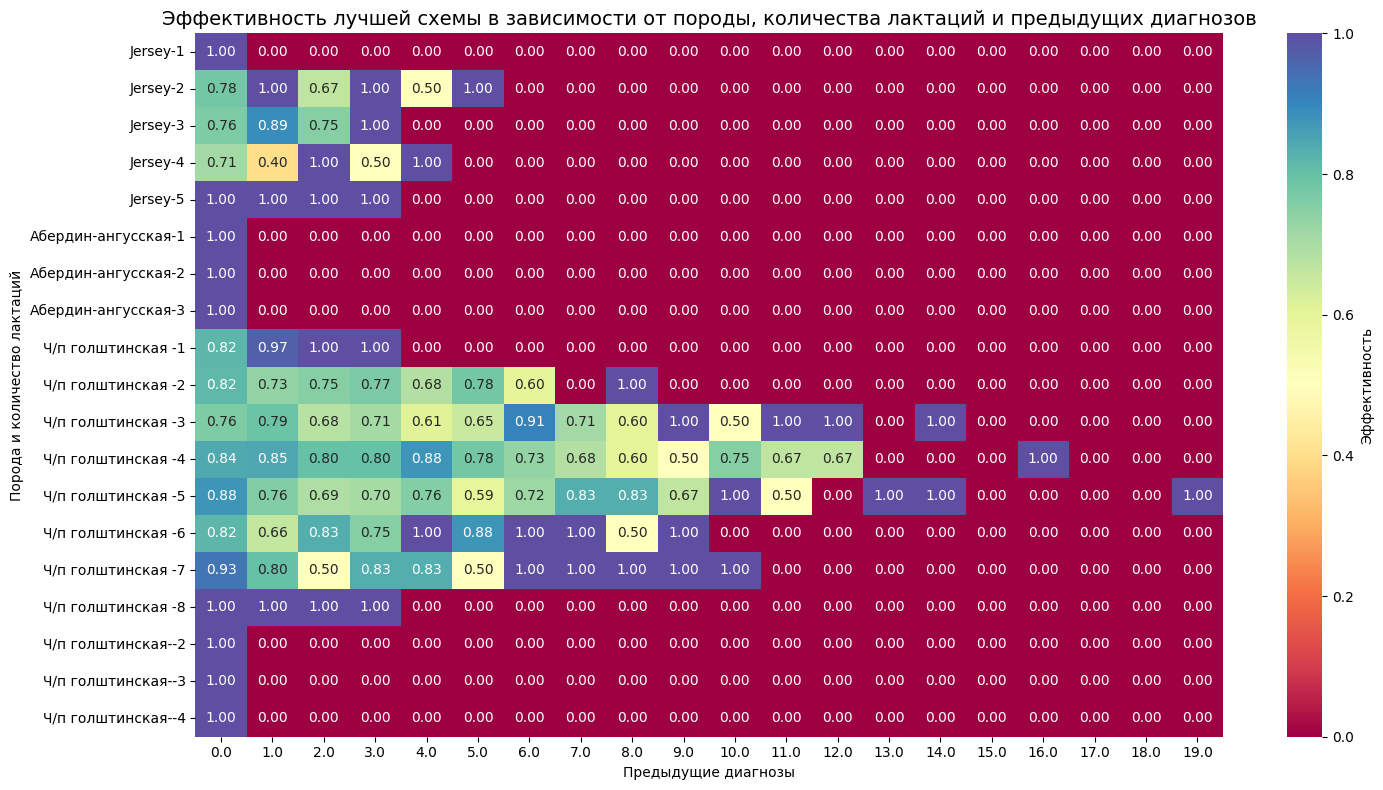

In [99]:
# --- Исходные параметры ---
days_after_treatment = 14  # Количество дней для анализа
target_treatment = ["Мастимакс", "Мастисепт", "Милоклокс"]

# --- Шаг 1: Отфильтровать данные по схеме лечения ---
# Замените `df` на ваш DataFrame
df["DescriptionReport"] = df["DescriptionReport"].fillna("").astype(str)
df["DiagName"] = df["DiagName"].fillna("").astype(str)

filtered_data = df[df["DescriptionReport"].str.contains("|".join(target_treatment), case=False, na=False)]

# --- Шаг 2: Добавить столбец количества предыдущих диагнозов ---
filtered_data["PreviousDiagnoses"] = filtered_data.groupby("number")["DateAndTime"].rank(method="first") - 1

# --- Шаг 3: Рассчитать эффективность лечения ---
def calculate_effectiveness(row, df, days_after_treatment):
    treatment_date = row["DateAndTime"]
    cow_id = row["number"]
    follow_up_period = treatment_date + timedelta(days=days_after_treatment)

    follow_up = df[
        (df["number"] == cow_id) & 
        (df["DateAndTime"] > treatment_date) & 
        (df["DateAndTime"] <= follow_up_period)
    ]
    
    # Успешность лечения
    if any("здоров" in diag.lower() for diag in follow_up["DiagName"]):
        return 1  # Успешно
    if len(follow_up) > 0:
        return 0  # Неуспешно
    return 1  # Предполагается успешным, если нет записей

filtered_data["Effective"] = filtered_data.apply(
    calculate_effectiveness, axis=1, args=(df, days_after_treatment)
)

# --- Шаг 4: Создать сводную таблицу ---
pivot_data = filtered_data.pivot_table(
    values="Effective",
    index=["breed", "LactationNumber"],
    columns="PreviousDiagnoses",
    aggfunc="mean"
).fillna(0)

# --- Шаг 5: Построить тепловую карту ---
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_data, cmap="Spectral", annot=True, fmt=".2f", cbar_kws={"label": "Эффективность"})
plt.title("Эффективность лучшей схемы в зависимости от породы, количества лактаций и предыдущих диагнозов", fontsize=14)
plt.xlabel("Предыдущие диагнозы")
plt.ylabel("Порода и количество лактаций")
plt.tight_layout()
plt.show()

**Вывод:**<br/>
Эффективность лучшей схемы лечения в зависимости от породы, количества лактаций и предыдущих диагнозов показывает, что  породы "Ч/п Голштинская" с 1 по 7 отел работает очень эффективно, 1 первого по 12 раз постановки диагноза. 
Также для породы "Jersey" схема работает очень эффективно  с 1 по 5 отел и с 1 по 3 раз постановки диагноза. Для породы "Ч/п Голштинская-" схема работает эффективно только, если корова болеет 1-й раз. 
Вывод: наиоучшая схема наиболее эффективна для породы: "Ч/п Голштинская".

**Логистическая регрессия поможет оценить влияние факторов на вероятность успешного лечения (Effective)**

In [92]:
# Подготовка данных
effectiveness_df["PastIllnesses"] = effectiveness_df["PastIllnesses"].fillna(0).astype(int)
effectiveness_df["Effective"] = effectiveness_df["Effective"].astype(int)

# Кодирование породы с помощью LabelEncoder
label_encoder = LabelEncoder()
effectiveness_df["breed_encoded"] = label_encoder.fit_transform(effectiveness_df["breed"])

# Признаки и целевая переменная
features = ["LactationNumber", "breed_encoded", "PastIllnesses"]
target = "Effective"

# Разделение данных
X = effectiveness_df[features]
y = effectiveness_df[target]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Логистическая регрессия
X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_sm)
logit_result = logit_model.fit()

# Предсказания на тестовой выборке
X_test_sm = sm.add_constant(X_test)
y_pred = logit_result.predict(X_test_sm)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Объединение предсказаний с исходными данными
effectiveness_df["Prediction"] = np.nan
effectiveness_df.loc[y_test.index, "Prediction"] = y_pred_binary

Optimization terminated successfully.
         Current function value: 0.652491
         Iterations 4


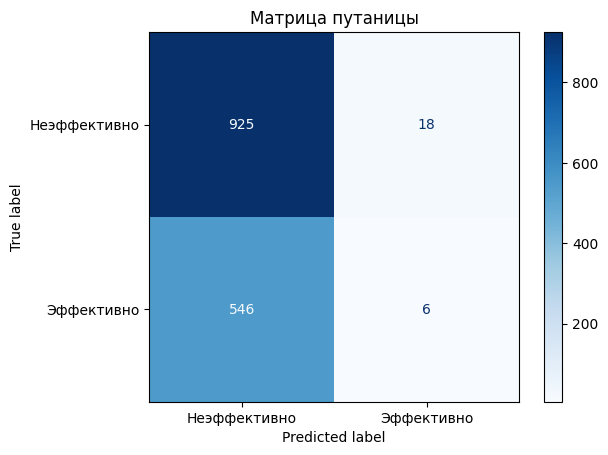

In [88]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Неэффективно", "Эффективно"])
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.show()

In [89]:
# Accuracy и Recall
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")

# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.62
Recall: 0.01

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       943
           1       0.25      0.01      0.02       552

    accuracy                           0.62      1495
   macro avg       0.44      0.50      0.39      1495
weighted avg       0.49      0.62      0.49      1495



<h4>Выводы</h4> 
1. Эффективнсть лечения по породам, без учета доли каждой породы в общем количестве всей выборки. Наибольшую эффективнось лечения показала порода "Абердин-ангусская". 
Наименьшуж эффективность показала порода "Ч/п голшинская-".<br/>
2. Доля каждой породы от общего чиста: самая большая доля: "Ч/п голштинская". Самая наименьшая доля: "Абердин-ангусская".<br/>
Эффективность лечения по породам (средневзвешенная): Наибольшую средневзвешенную эффективность лечения показала порода "Ч/п голштинская".<br/>
3. Число случаев неэффективного лечения растет с число отелов линейно до 3 отела, потом экспоненциально падает. Падение возможно со сниженем также чила отелов после 3. <br/>
4. Для всех пород эффективность лечения экпоненциально падает с ростом количества прошлых заболеваний. <br/>
5. Для породы "Jersey" эффективность лечения падает после 6 раза заболевания (постанови диагноза). <br/>
Для породы "Голштинская" эффективность лечения падает с ростом количества отелов: начиная с 7 отела резко падает эффективность дечения. Для породы "Голштинская" эффективность лечения падает с ростом количества отелов: начиная с 7. отела резко падает эффективность дечения. Для этой породы с 10 отела дечение оказывается неэффективным независимо от 
количества предыдущих диагнзов.<br/>
Для породы "Голштинская" эффективность лечения падает с ростом количества количества прощлых заболеваний: начиная с постновки 11 диагноза начинается резкий спад эффективноси лечения. <br/>
Порода "Голштинская-" менее устойчива к схемам лечения, начиная с первого отела и независимо от количества предыдущих заболевамний, относительно других пород, где явно прослеживается зависимость <br/>
эффективности лечения от количества отелов и количества предшествующих диагнозов.<br/>
8. Эффективность лучшей схемы лечения в зависимости от породы, количества лактаций и предыдущих диагнозов показывает, что  породы "Ч/п Голштинская" с 1 по 7 отел работает очень эффективно, 1 первого по 12 раз постановки диагноза. 
Также для породы "Jersey" схема работает очень эффективно  с 1 по 5 отел и с 1 по 3 раз постановки диагноза. Для породы "Ч/п Голштинская-" схема работает эффективно только, если корова болеет 1-й раз. 
Вывод: наиоучшая схема наиболее эффективна для породы: "Ч/п Голштинская".
<br/>

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv('C:\\Users\\dplog\\YandexDisk\\текучка\\ЛабИИ\\коровы\\mastities_analytic.csv')
data

,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName
0,8036,Пташка,Ч/п голштинская-,4,27.12.2013 0:00:00,24.07.2009 0:00:00,Кл.маст. Кобакт,Абсцесс 30 d 1X1ml,Admin
1,8778,Эврика,Ч/п голштинская-,6,26.08.2012 0:00:00,15.04.2010 0:00:00,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
2,8614,Таврия,Ч/п голштинская-,5,26.08.2012 0:00:00,24.01.2010 0:00:00,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
3,103602,Нота,Ч/п голштинская,5,24.02.2016 0:00:00,16.02.2011 0:00:00,Гнойный абсцесс доли,Абсцесс 30 d 1X1ml,Admin
4,992,Абрикоса,Ч/п голштинская-,7,02.09.2012 0:00:00,16.04.2007 0:00:00,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
...,...,...,...,...,...,...,...,...,...
11002,22824,Волга,Ч/п голштинская,1,18.10.2024 16:00:00,13.07.2022 0:00:00,Клинический мастит,"Тиломаст 3 d 1X1pcs Интрацистернально, Моксифо...",Семыкин А.К.
11003,20974,Горная,Ч/п голштинская,3,20.10.2024 14:00:00,08.09.2020 0:00:00,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11004,21822,Белка,Ч/п голштинская,2,20.10.2024 14:00:00,23.07.2021 0:00:00,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11005,171004,Опора,Jersey,5,20.10.2024 14:00:00,13.11.2017 0:00:00,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.


Перевод дат в datestamp

In [3]:
data['DateAndTime'] = pd.to_datetime(data.DateAndTime)
data['BirthDate'] = pd.to_datetime(data.BirthDate)

C:\Users\dplog\AppData\Local\Temp\ipykernel_11428\1990378943.py:1: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['DateAndTime'] = pd.to_datetime(data.DateAndTime)
C:\Users\dplog\AppData\Local\Temp\ipykernel_11428\1990378943.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['BirthDate'] = pd.to_datetime(data.BirthDate)


In [4]:
data['UserName'] = data['UserName'].str.replace(' Винокович  В.А.','Винокович В.А.')
data['UserName'] = data['UserName'].str.replace(' Винокович В.А.','Винокович В.А.')
data['UserName'] = data['UserName'].str.replace('Калюжная О. ветеринар 1','Калюжная О.В')
data['UserName'] = data['UserName'].str.replace('Овчарова  А.А.','Овчарова А.А.')
data['UserName'] = data['UserName'].str.replace('Мартыненко Г.Н.','Мартыненко Г.Н')
data['UserName'] = data['UserName'].str.replace('Лисицин Д. С.','Лисицин Д.С.')
data['UserName'] = data['UserName'].str.replace('КочураЕ.В.','Кочура Е.В')
data['UserName'] = data['UserName'].str.replace('Колюжная О.','Калюжная О.В')

In [5]:
data = data.sort_values(['DateAndTime','number'])
data.head(20)

,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName
2,8614,Таврия,Ч/п голштинская-,5,2012-08-26,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
613,8614,Таврия,Ч/п голштинская-,5,2012-08-26,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
1,8778,Эврика,Ч/п голштинская-,6,2012-08-26,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
612,8778,Эврика,Ч/п голштинская-,6,2012-08-26,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
4,992,Абрикоса,Ч/п голштинская-,7,2012-09-02,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
614,992,Абрикоса,Ч/п голштинская-,7,2012-09-02,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
6,8936,Горная,Ч/п голштинская,5,2012-09-05,2010-07-02,Мастит суб.клин,Unknown 1 d 1X0.1ml,Admin
616,8936,Горная,Ч/п голштинская,5,2012-09-05,2010-07-02,Мастит суб.клин,Unknown 1 d 1X0.1ml,Admin
8,8576,Нота,Ч/п голштинская-,6,2012-09-10,2010-01-01,Мастит суб.клин,Unknown 1 d 1X0.1ml,Admin
9,8576,Нота,Ч/п голштинская-,6,2012-09-10,2010-01-01,Мастит суб.клин,Unknown 1 d 1X0.1ml,Admin


In [6]:
data.reset_index(inplace=True,drop=True)
data.reset_index(inplace=True)
data


,index,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName
0,0,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
1,1,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
2,2,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
3,3,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
4,4,992,Абрикоса,Ч/п голштинская-,7,2012-09-02 00:00:00,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin
...,...,...,...,...,...,...,...,...,...,...
11002,11002,22824,Волга,Ч/п голштинская,1,2024-10-18 16:00:00,2022-07-13,Клинический мастит,"Тиломаст 3 d 1X1pcs Интрацистернально, Моксифо...",Семыкин А.К.
11003,11003,20974,Горная,Ч/п голштинская,3,2024-10-20 14:00:00,2020-09-08,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11004,11004,21822,Белка,Ч/п голштинская,2,2024-10-20 14:00:00,2021-07-23,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.
11005,11005,171004,Опора,Jersey,5,2024-10-20 14:00:00,2017-11-13,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.


### Количество отелов по породам

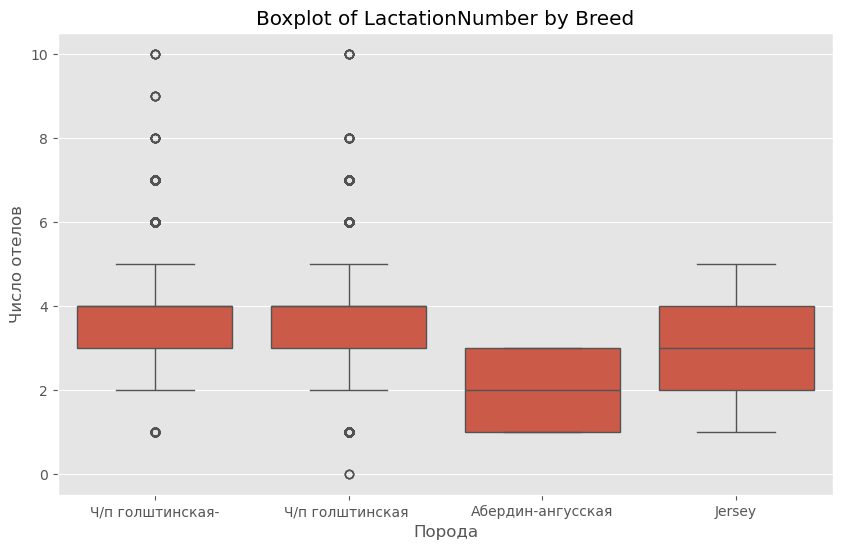

In [7]:
grouped = data.groupby('breed')['LactationNumber']
plt.figure(figsize=(10, 6))
sns.boxplot(x='breed', y='LactationNumber', data=data)
plt.title('Boxplot of LactationNumber by Breed')
plt.xlabel('Порода')
plt.ylabel('Число отелов')
plt.show()

In [10]:
data['is_ill'] = data['DiagName'].str.contains('здоров',case=False, na=False)
data

C:\Users\dplog\AppData\Local\Temp\ipykernel_11428\1255451922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_ill'] = data['DiagName'].str.contains('здоров',case=False, na=False)


,index,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName,days_target,is_ill
0,0,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,<NA>,False
1,1,8614,Таврия,Ч/п голштинская-,5,2012-08-26 00:00:00,2010-01-24,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,<NA>,False
2,2,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,<NA>,False
3,3,8778,Эврика,Ч/п голштинская-,6,2012-08-26 00:00:00,2010-04-15,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,<NA>,False
4,4,992,Абрикоса,Ч/п голштинская-,7,2012-09-02 00:00:00,2007-04-16,Мастит суб.клин,Суб.клиника 4 d 1X1ml,Admin,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...
11002,11002,22824,Волга,Ч/п голштинская,1,2024-10-18 16:00:00,2022-07-13,Клинический мастит,"Тиломаст 3 d 1X1pcs Интрацистернально, Моксифо...",Семыкин А.К.,<NA>,False
11003,11003,20974,Горная,Ч/п голштинская,3,2024-10-20 14:00:00,2020-09-08,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,<NA>,False
11004,11004,21822,Белка,Ч/п голштинская,2,2024-10-20 14:00:00,2021-07-23,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,<NA>,False
11005,11005,171004,Опора,Jersey,5,2024-10-20 14:00:00,2017-11-13,Клинический мастит,"Марбобел Актив 1 d 1X40ml Внутримышечно, Клокс...",Семыкин А.К.,<NA>,False


Всего фактов выздоровления

##### По корове number=4 ничего о истории ьолезни не известно! Она была и будет здоровой )))

In [8]:
data = data[data['number'] != 4]

In [11]:
data['days_target'] = pd.NA

for cow_id, group in data.groupby("number"):
    for i, row in group.iterrows():
        if not row["is_ill"]:
            treatment_date = row["DateAndTime"]
        else:
            recovery_date = row["DateAndTime"]
            days = (recovery_date - treatment_date).days
            data.loc[i,'days_target'] = days

C:\Users\dplog\AppData\Local\Temp\ipykernel_11428\1858250975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_target'] = pd.NA


In [12]:
data[data['days_target'].notna()]['days_target'].value_counts()[:14]

days_target
4     364
5     353
3     314
6     307
2     265
7     189
8     132
9     115
1     109
10     76
11     72
12     39
13     35
0      25
Name: count, dtype: int64

In [13]:
data_with_days = data[(data['days_target']>0) & (data['days_target']<30)]
data_with_days

,index,number,Name,breed,LactationNumber,DateAndTime,BirthDate,DiagName,DescriptionReport,UserName,days_target,is_ill
980,980,1990,Встреча,Ч/п голштинская,7,2016-07-18 17:33:15,2008-04-01,Здорова 1,NaN,Мартыненко Г.Н,5,True
1063,1063,250,Потеря,Ч/п голштинская,4,2016-08-18 15:15:59,2011-10-14,Здорова 1,NaN,Мартыненко Г.Н,8,True
1094,1094,11075,Сова,Ч/п голштинская,5,2016-08-24 16:48:09,2010-08-02,Здорова 1,NaN,Мартыненко Г.Н,13,True
1097,1097,14488,Цапля а/с,Ч/п голштинская,2,2016-08-24 16:48:09,2014-07-18,Здорова 1,NaN,Мартыненко Г.Н,3,True
1098,1098,14120,Русалка,Ч/п голштинская,3,2016-08-25 15:51:54,2014-02-12,Здорова 1,NaN,Мартыненко Г.Н,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...
10634,10634,191188,Карта,Ч/п голштинская,3,2024-03-27 14:00:00,2019-12-01,Здорова 1,NaN,Винокович В.А.,6,True
10684,10684,22312,Гера,Jersey,1,2024-05-08 13:00:00,2022-03-02,Здорова 1,NaN,Винокович В.А.,10,True
10685,10685,191024,Муравка,Jersey,4,2024-05-08 13:00:00,2019-11-04,Здорова 1,NaN,Винокович В.А.,10,True
10686,10686,201200,Нива,Ч/п голштинская,3,2024-05-08 13:00:00,2020-10-14,Здорова 1,NaN,Винокович В.А.,13,True


In [14]:
drop_data_with_days = data_with_days.drop(columns=['index','Name','DiagName','UserName','DescriptionReport','is_ill'])
drop_data_with_days

,number,breed,LactationNumber,DateAndTime,BirthDate,days_target
980,1990,Ч/п голштинская,7,2016-07-18 17:33:15,2008-04-01,5
1063,250,Ч/п голштинская,4,2016-08-18 15:15:59,2011-10-14,8
1094,11075,Ч/п голштинская,5,2016-08-24 16:48:09,2010-08-02,13
1097,14488,Ч/п голштинская,2,2016-08-24 16:48:09,2014-07-18,3
1098,14120,Ч/п голштинская,3,2016-08-25 15:51:54,2014-02-12,10
...,...,...,...,...,...,...
10634,191188,Ч/п голштинская,3,2024-03-27 14:00:00,2019-12-01,6
10684,22312,Jersey,1,2024-05-08 13:00:00,2022-03-02,10
10685,191024,Jersey,4,2024-05-08 13:00:00,2019-11-04,10
10686,201200,Ч/п голштинская,3,2024-05-08 13:00:00,2020-10-14,13


In [15]:
drop_data_with_days['days_target'].mean()

5.849878934624697

### Гистограмма дней лечения до момента выздоровления

<Axes: >

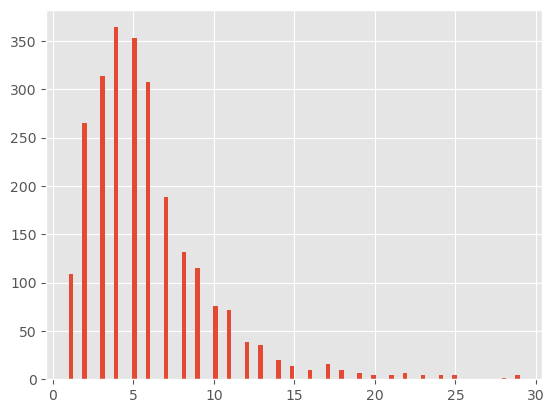

In [16]:
drop_data_with_days['days_target'].hist(bins=100)

## Прогнозная модель и анализ факторов влияющих на выздоровление

In [17]:
X = drop_data_with_days.drop(columns = ['number','BirthDate','DateAndTime','days_target'])
X.dropna(inplace=True)

In [18]:
y = drop_data_with_days['days_target'].dropna()

In [19]:
X = pd.get_dummies(X, columns=['breed'], prefix=['breed'])

In [20]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [21]:
lasso_regressor = Lasso()
lasso_regressor.fit(X_train, y_train)

Lasso()

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [23]:
y_test_prediction = lasso_regressor.predict(X_test)

print('Test MAE: ', mean_absolute_error(y_test, y_test_prediction))

Test MAE:  2.696860453761271


In [24]:
lasso_regressor.coef_

array([ 0., -0.,  0., -0.,  0.])

In [25]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

y_predicted = model_linear.predict(X_test)
print('Test MAE: ', mean_absolute_error(y_test, y_predicted))

Test MAE:  2.7129990388772045


In [26]:
model_linear.coef_

array([ 0.02084217, -0.94209075,  1.8061349 , -1.02506034,  0.1610162 ])

### Выводы: По прогнозной модели
Ни один из признаков (количество лактаций, порода, ) существенно не влияет на прогноз (в днях) на выздоровление коров.

#### Реклмендуется добавить новые признаки признаки в прогнозую модель.

При анализе линейной модели зависимости признаков:
* Число лактаций
* Порода
* Прошлая болезнь
от эффективности схемы лечения (эффективно, неэффективно)
Показатели признаков не существенно влияют на прогноз классификации.
**Признак Число лактаций влияет обратно на эффективность лечения**